In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from entropy_bounds.utils import optimization_cf
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array
from entropy_bounds.entropy_bounds import compute_ate_bounds


import matplotlib.pyplot as plt
import seaborn as sns
import math
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns', None)


In [31]:
data['entropy_U']

0       0.999896
1       0.999434
2       0.999815
3       0.999954
4       0.999954
          ...   
1995    0.997737
1996    0.996662
1997    0.996662
1998    0.999711
1999    0.998846
Name: entropy_U, Length: 2000, dtype: float64

In [7]:
def plot_smoothed_ate_vs_ci(dataframe, window=1):
    """
    Plot smoothed ATE_true and 2SLS confidence intervals from the given dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns 'ATE_true', '2SLS_CI_lower', '2SLS_CI_upper', and 'b_X_Y'.
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Smoothen the data using a rolling average
    dataframe['ATE_true_smooth'] = dataframe['ATE_true'].rolling(window=window, center=True).mean()
    dataframe['entropyBounds_bound_lower_smooth'] = dataframe['entropyBounds_bound_lower'].rolling(window=window, center=True).mean()
    dataframe['entropyBounds_bound_upper_smooth'] = dataframe['entropyBounds_bound_upper'].rolling(window=window, center=True).mean()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataframe, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
    sns.lineplot(data=dataframe, x='b_X_Y', y='entropyBounds_bound_lower_smooth', label='Lower Bound', color='orange')
    sns.lineplot(data=dataframe, x='b_X_Y', y='entropyBounds_bound_upper_smooth', label='Upper Bound', color='green')
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.title('entropyBounds vs $ATE_{true}$ (smoothed out)')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('ATE Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# minimal working example
sim = data.iloc[0]

df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

entr = 0.7

# Compute ATE bounds
ate_lower, ate_upper = compute_ate_bounds(df['X'].to_numpy(), df['Y'].to_numpy(), entr)

# Check if true ATE is within bounds
bounds_valid = ate_lower <= sim['ATE_true'] <= ate_upper

# Collect results
result = {
    'ATE_true': sim['ATE_true'],
    'bound_lower': ate_lower,
    'bound_upper': ate_upper,
    'bound_width': ate_upper - ate_lower,
    'bounds_valid': bounds_valid
}

# Display
for key, value in result.items():
    print(f"{key}: {value}")

ATE_true: -0.6494981193401556
bound_lower: -0.7589942481344406
bound_upper: 0.202100234716181
bound_width: 0.9610944828506216
bounds_valid: True


In [45]:
df_results = data.copy()
for idx, sim in df_results.iterrows():
    entr = np.random.uniform(0,1)
    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

    # Compute ATE bounds
    ate_lower, ate_upper = compute_ate_bounds(df['X'].to_numpy(), df['Y'].to_numpy(), entr, method='cf')

    # Check if true ATE is within bounds
    bounds_valid = ate_lower <= sim['ATE_true'] <= ate_upper

    # Collect results
    result = {
        'ATE_true': sim['ATE_true'],
        'bound_lower': ate_lower,
        'bound_upper': ate_upper,
        'bound_width': ate_upper - ate_lower,
        'bounds_valid': bounds_valid
    }

    df_results.at[idx, 'entropyBounds_H(conf)_UB'] = entr
    df_results.at[idx, 'entropyBounds_bound_lower'] = ate_lower
    df_results.at[idx, 'entropyBounds_bound_upper'] = ate_upper
    df_results.at[idx, 'entropyBounds_bound_width'] = ate_upper - ate_lower
    df_results.at[idx, 'entropyBounds_bounds_valid'] = bounds_valid

In [ ]:
#random_entropy_0_1 = df_results.copy() #entropy randomly sampled from [0,1]
# df_results.drop(columns=['ATE_true_smooth', 'entropyBounds_bound_lower_smooth', 'entropyBounds_bound_upper_smooth'], inplace=True, errors='ignore')
# df_results.to_pickle('binaryIV_results.pkl')

Entropy H(conf)_UB: 0.4982640369082845
Invalid Bounds: 26
Average Bound Width: 0.8688001291283783
Average U entropy: 0.9986005913022207
Invalid Rate: 1.30%


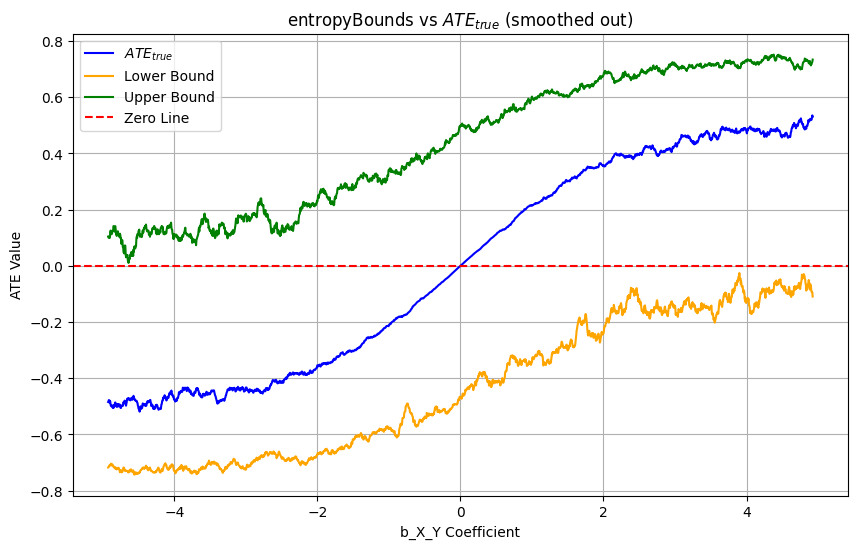

In [46]:
print(f'Entropy H(conf)_UB: {df_results["entropyBounds_H(conf)_UB"].mean()}')
print(f"Invalid Bounds: {df_results[df_results['entropyBounds_bounds_valid'] == False].shape[0]}")
print(f"Average Bound Width: {df_results['entropyBounds_bound_width'].mean()}")
print(f"Average U entropy: {df_results['entropy_U'].mean()}")
print(f"Invalid Rate: {df_results[df_results['entropyBounds_bounds_valid'] == False].shape[0] / df_results.shape[0]:.2%}")

plot_smoothed_ate_vs_ci(df_results, window=30)

Invalid Bounds: 4
Average Bound Width: 0.9999893274665526
Average U entropy: 0.6921771843666286


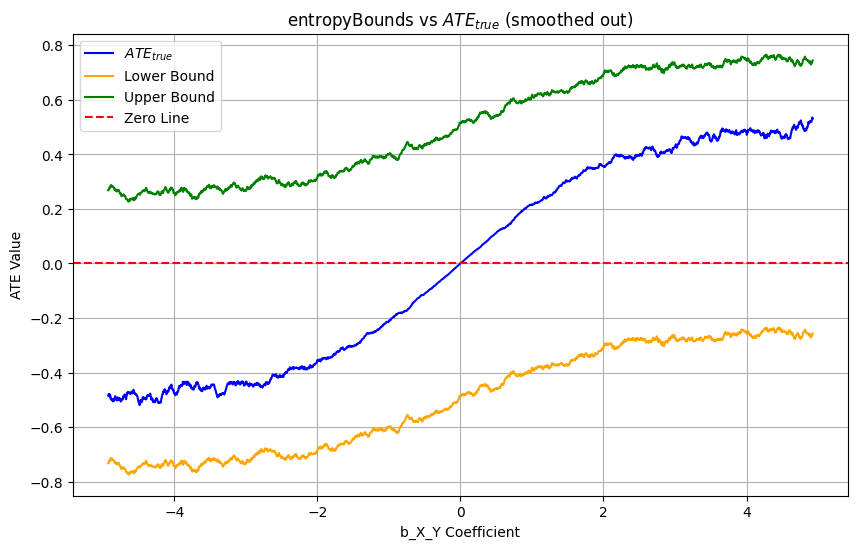

In [117]:

print(f"Invalid Bounds: {df_results[df_results['entropyBounds_bounds_valid'] == False].shape[0]}")
print(f"Average Bound Width: {df_results['entropyBounds_bound_width'].mean()}")
print(f"Average U entropy: {df_results['entropy_U'].mean()}")

plot_smoothed_ate_vs_ci(df_results, window=30)

C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                     Generalized Linear Model Regression Results                     
Dep. Variable:     entropyBounds_bound_width   No. Observations:                 1974
Model:                                   GLM   Df Residuals:                     1971
Model Family:                       Binomial   Df Model:                            2
Link Function:                         logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -372.25
Date:                       Thu, 08 May 2025   Deviance:                       74.674
Time:                               11:54:53   Pearson chi2:                     68.5
No. Iterations:                            7   Pseudo R-squ. (CS):             0.1988
Covariance Type:                   nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

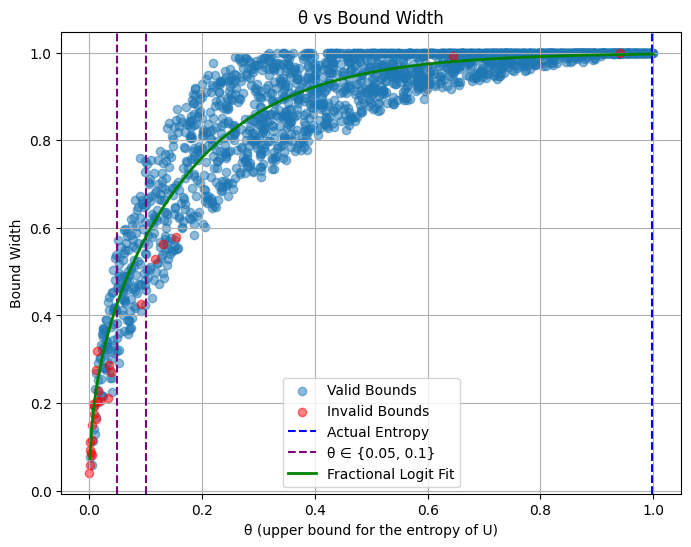

In [ ]:
## RCT: entropy UB --> bound width
# Load the data
random_entropy_0_1 = df_results.copy()
# Prepare
df_ols = random_entropy_0_1[random_entropy_0_1['entropyBounds_bounds_valid'] == True].copy()
df_ols['theta'] = df_ols['entropyBounds_H(conf)_UB']
df_ols['log_theta'] = np.log(df_ols['theta'] + 1e-5)  # Add small value to avoid log(0)

# Fractional Logit Model with log(theta)
model = smf.glm(formula="entropyBounds_bound_width ~ theta + log_theta",
                data=df_ols,
                family=sm.families.Binomial(link=sm.families.links.logit()))
result = model.fit()

print(result.summary())

# Create prediction grid
theta_pred = np.linspace(df_ols['theta'].min(), df_ols['theta'].max(), 300)
X_pred = pd.DataFrame({'theta': theta_pred, 'log_theta': np.log(theta_pred + 1e-5)})

# Predict fitted values
y_pred = result.predict(X_pred)

# Calculate actual entropy 
actual_entropy = df_ols['entropy_U'].mean()

# Scatter plot + fitted curve
plt.figure(figsize=(8,6))
plt.scatter(df_ols['entropyBounds_H(conf)_UB'], df_ols['entropyBounds_bound_width'], alpha=0.5, label='Valid Bounds')
plt.scatter(random_entropy_0_1[random_entropy_0_1['entropyBounds_bounds_valid'] == False]['entropyBounds_H(conf)_UB'],
            random_entropy_0_1[random_entropy_0_1['entropyBounds_bounds_valid'] == False]['entropyBounds_bound_width'],
            color='red', alpha=0.5, label='Invalid Bounds')
# plt.axvline(actual_entropy, color='blue', linestyle='--', label='Actual Entropy')
# plt.axvline(0.1, color='purple', linestyle='--', label='θ ∈ {0.05, 0.1}')
# plt.axvline(0.05, color='purple', linestyle='--')

# plt.plot(theta_pred, y_pred, color='green', linewidth=2, label='Fractional Logit Fit')
plt.xlabel(r'θ (upper bound for the entropy of U)')
plt.ylabel('Bound Width')
plt.title(r'θ vs Bound Width')
plt.grid(True)
plt.legend()
plt.show()